In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from matplotlib_venn import venn3, venn3_circles

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Election Reflection

## Model Recap and Predictions

### Model Specification

My final model used to predict election outcomes was a random forest model, which used incumbency, economic, and polling factors to predict national 2-party vote and seat share.

#### Inputs

The factors used in the model were:

1. Incumbency
- Year of Election
- Midterm Year Indicator
- Party of the President
- 2 Party seat share from the prior election (GOP)
- 2 party vote share from the prior election (GOP)
2. Economy
- Consumer Sentiment Index (absolute value at time of election)
- Consumer Sentiment Index (change from start of Congress (Q1 -> Q7 Change))
- GDP Growth (annual growth at time of election)
- GDP Growth (change from start of Congress (Q1 -> Q7 Change))
- RDI Growth (annual growth at time of election)
- RDI Growth (change from start of Congress (Q1 -> Q7 Change))
3. Polling
- Presidential Approval (election year average)
- Presidential Approval (Election October & November average)
- Generic Congressional Ballot (election year average)
- Generic Congressional Ballot (Election October & November average)

#### Model Type

My final model was a random forest model, which I chose to use because it had the best out of sample performance. However, I also tried using a pure linear regression model, as well as linear regression with feature selection (LASSO regression), and these models with polynomial interaction features.

### Predictions

My final point esteimate prediction from the model was the following:

In [3]:
all_types_data = pickle.load(open('all_types_data.p', 'rb'))
data_2022 = pd.read_csv("data_2022.csv",index_col=0)
train_df_nona = pd.read_csv("train_df_nona.csv",index_col=0)
train_y = pd.read_csv("train_y.csv",index_col=0)
final_model = pd.DataFrame(all_types_data[('Incumbent Factors', 'Economic Factors', 'Polling Factors')]).loc[5,"model"]
preds = final_model.predict(data_2022)
pred_seats = preds[0][0]
pred_votes = preds[0][1]

print("Predicted 2022 Rep Seats:", round(435*pred_seats))
print("Predicted 2022 Rep Votes:", round(100*pred_votes, 2))

Predicted 2022 Rep Seats: 224
Predicted 2022 Rep Votes: 50.35


I then had three ways of generating prediction intervals with this random forest model.

1. Each Decision Tree as an i.i.d predictor
    - Since a random forest is constructed as a collection of decision trees, I could use each decision tree as an i.i.d predictor. This is the method I used to generate the prediction intervals in the model writeup. Therefore, I then take the X% quantiles of the generated predictions.

2. Normal Residuals Assumption
    - I can assume that all the residuals are normally distributed, and use this assumption to create a prediction interval based on the residuals standard error. For both this and the next method, the residuals are the out of sample residuals (leave one out validation).

3. Recently Normal Residuals Assumption
    - I can assume that recently the residuals have been normally distributed, and therefore use the 2010+ residuals to generate the standard error.

In [4]:
predictions = [
    {"seat_share": final_model.estimators_[i].predict(data_2022.to_numpy())[0][0], 
    "vote_share": final_model.estimators_[i].predict(data_2022.to_numpy())[0][1]} 
    for i in range(len(final_model.estimators_))
]

pis = pd.DataFrame(predictions).quantile([0.025, 0.10, 0.5, 0.90, 0.975])

print("Random Forest 95% Seat Share PI:", (round(435 * pis.loc[0.025,"seat_share"]), round(435 * pis.loc[0.975,"seat_share"])))
print("Random Forest 80% Seat Share PI:", (round(435 * pis.loc[0.1,"seat_share"]), round(435 * pis.loc[0.9,"seat_share"])))

print("Random Forest 95% Vote Share PI:", (round(100 * pis.loc[0.025,"vote_share"], 2), round(100 * pis.loc[0.975,"vote_share"], 2)))
print("Random Forest 80% Vote Share PI:", (round(100 * pis.loc[0.1,"vote_share"], 2), round(100 * pis.loc[0.9,"vote_share"], 2)))

residuals = pd.DataFrame(all_types_data[('Incumbent Factors', 'Economic Factors', 'Polling Factors')]).loc[5,"residuals"]

print("Normal Residuals 95% Seat Share PI:", (round(435 * stats.norm.ppf(0.025, pred_seats, residuals.std(axis=0)[0][0])), round(435 * stats.norm.ppf(0.975, pred_seats, residuals.std(axis=0)[0][0]))))
print("Normal Residuals 80% Seat Share PI:", (round(435 * stats.norm.ppf(0.1, pred_seats, residuals.std(axis=0)[0][0])), round(435 * stats.norm.ppf(0.9, pred_seats, residuals.std(axis=0)[0][0]))))

print("Normal Residuals 95% Votes Share PI:", (round(100 * stats.norm.ppf(0.025, pred_votes, residuals.std(axis=0)[0][0]),2), round(100 * stats.norm.ppf(0.975, pred_votes, residuals.std(axis=0)[0][0]),2)))
print("Normal Residuals 80% Votes Share PI:", (round(100 * stats.norm.ppf(0.1, pred_votes, residuals.std(axis=0)[0][1]),2), round(100 * stats.norm.ppf(0.9, pred_votes, residuals.std(axis=0)[0][1]),2)))

print("Recent Residuals 95% Seat Share PI:", (round(435 * stats.norm.ppf(0.025, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0])), round(435 * stats.norm.ppf(0.975, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0]))))
print("Recent Residuals 80% Seat Share PI:", (round(435 * stats.norm.ppf(0.1, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0])), round(435 * stats.norm.ppf(0.9, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0]))))

print("Recent Residuals 95% Votes Share PI:", (round(100 * stats.norm.ppf(0.025, pred_votes, residuals[-4:,:,:].std(axis=0)[0][0]),2), round(100 * stats.norm.ppf(0.975, pred_votes, residuals[-4:,:,:].std(axis=0)[0][1]),2)))
print("Recent Residuals 80% Votes Share PI:", (round(100 * stats.norm.ppf(0.1, pred_votes, residuals[-4:,:,:].std(axis=0)[0][1]),2), round(100 * stats.norm.ppf(0.9, pred_votes, residuals[-4:,:,:].std(axis=0)[0][1]),2)))

Random Forest 95% Seat Share PI: (169, 246)
Random Forest 80% Seat Share PI: (178, 246)
Random Forest 95% Vote Share PI: (44.44, 53.6)
Random Forest 80% Vote Share PI: (44.91, 53.47)
Normal Residuals 95% Seat Share PI: (182, 267)
Normal Residuals 80% Seat Share PI: (197, 252)
Normal Residuals 95% Votes Share PI: (40.57, 60.13)
Normal Residuals 80% Votes Share PI: (47.24, 53.46)
Recent Residuals 95% Seat Share PI: (206, 243)
Recent Residuals 80% Seat Share PI: (212, 236)
Recent Residuals 95% Votes Share PI: (46.16, 53.84)
Recent Residuals 80% Votes Share PI: (48.07, 52.64)


These methods clearly each have their own unique slants:

1. Random Forest: Our 95\% and 80\% confidence intervals are incredibly close, because the random forest model essentially conducts a nearest neighbor approach, and many of the nearest neighbors are at the edges.
2. Standard Normal: this shows a more spread out probability. However, it is symmetric (due to an assumption of zero mean), which would seem to unfairly favor Democrats (we would think it is unlikely for Dems to recieve this much vote share).
3. Recent Normal: this seems to be the right balance of outcomes in the modern age, because it is based on the residuals from the modern age.

One way to verify our recency assumption is to view the residuals over time:

Text(0.5, 1.0, 'Seat Share Out of Sample Residuals')

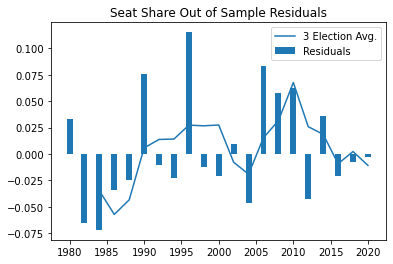

In [5]:
plt.bar(range(1980, 2022, 2), residuals[:,0,0], label="Residuals")
plt.plot(range(1984, 2022, 2), pd.DataFrame(residuals[:,0,0]).rolling(3).mean()[2:].to_numpy(), label="3 Election Avg.")
plt.legend()
plt.title("Seat Share Out of Sample Residuals")

Text(0.5, 1.0, 'Vote Share Out of Sample Residuals')

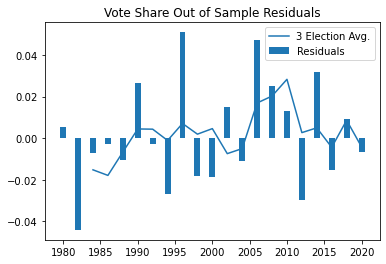

In [6]:
plt.bar(range(1980, 2022, 2), residuals[:,0,1], label="Residuals")
plt.plot(range(1984, 2022, 2), pd.DataFrame(residuals[:,0,1]).rolling(3).mean()[2:].to_numpy(), label="3 Election Avg.")
plt.legend()
plt.title("Vote Share Out of Sample Residuals")

It does not appear conclusive whether these residuals have moerated over time. It seems that the variance of these residuals may be decreasing in the past 3 elections, but prior to 2012, the residuals were quite large during the 2000s.

However based on this, I will use method 3 for my prediction intervals for the rest of this write up.

In summary, my prediction is as follows:

**Seat Prediction**: 224 R Seats, 95% PI: (206, 243), 80% PI: (212, 236)

**Vote Predictions**: 50.35, 95% PI: (46.16, 53.84), 80% PI: (48.07, 52.64)

### Comparison to Actual Results

#### Current Results

As of 11/22, the actual results are as follows:

NYTimes Seat Lead: 213 D, 222 R

Cook House Vote Tracking: 48.3 D, 51.7 R 

#### Absolute Error

Therefore, my predictions have the following absolute error:

Seats: +2 (224 v 222 R seats)
Popular Vote: -1.3 (50.4 v 51.7 R)

#### Comparison to Prior Residuals

One comparison we may want to make is comparing how our 2022 error compared to our model's previous error.

In [7]:
residual_df = pd.DataFrame()
residual_df["Year"] = range(1980, 2022, 2)
residual_df["Seat Resid"] = residuals[:,0,0]
residual_df["Vote Resid"] = residuals[:,0,1]

residual_df = residual_df.append({"Year": 2022, "Seat Resid": pred_seats - 224/435, "Vote Resid": pred_votes - 51.7/100}, ignore_index=True)

residual_df = residual_df.set_index("Year")

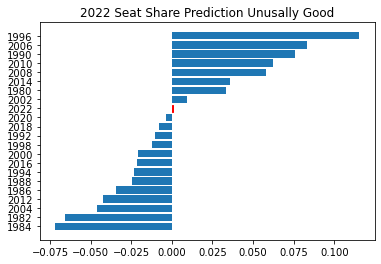

In [8]:
barlist = plt.barh(residual_df.sort_values("Seat Resid").index.astype(int).astype(str), residual_df.sort_values("Seat Resid")["Seat Resid"])
barlist[13].set_color("r")
plt.title("2022 Seat Share Prediction Unusally Good")
plt.show()

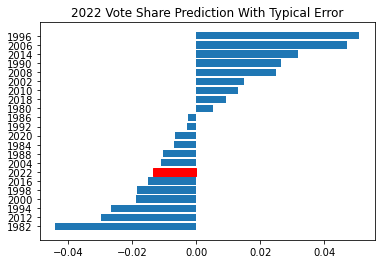

In [9]:
barlist = plt.barh(residual_df.sort_values("Vote Resid").index.astype(int).astype(str), residual_df.sort_values("Vote Resid")["Vote Resid"])
barlist[6].set_color("r")
plt.title("2022 Vote Share Prediction With Typical Error")
plt.show()

From these graphs we see that in terms of seat share, our model had its best possible outcome (only a two seat difference), but in terms of vote share, our model's performance was much more typical. 

I'd likely chalk this outcome up to luck with regards to the votes-seats curve, which was remarkably flat. Essentially, my model predicted an outcome more favorable for Democrats with the votes, but assumed a more gerrymandered curve, and this correction happened to align much more closely with the election outcome.

#### Comparison to Predicted Outcomes

Another comparison we may want to conduct is comparing the result to the prior probabilities we had assigned to each event occuring.

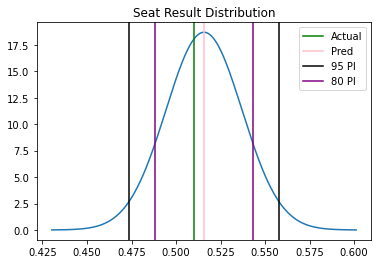

In [10]:
mu = pred_seats
sigma = residuals[-4:,:,:].std(axis=0)[0][0]

x = np.linspace(mu-4*sigma,mu+4*sigma,1000)

plt.plot(x, stats.norm.pdf(x, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0]))

plt.axvline(222/435, label="Actual", color="green")

plt.axvline(mu, label="Pred", color="pink")

plt.axvline(stats.norm.ppf(0.025, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0]), label="95 PI", color="black")
plt.axvline(stats.norm.ppf(0.975, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0]), color="black")

plt.axvline(stats.norm.ppf(0.1, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0]), label="80 PI", color="purple")
plt.axvline(stats.norm.ppf(0.9, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0]), color="purple")

plt.legend()

plt.title("Seat Result Distribution")

plt.show()

Since seats are discrete, we can also turn this into a per-seat probability.

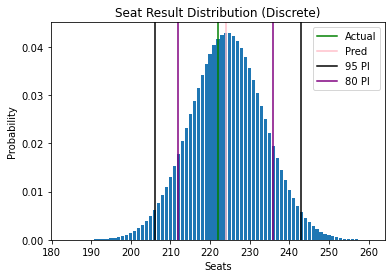

In [11]:
mu = pred_seats
sigma = residuals[-4:,:,:].std(axis=0)[0][0]

probs = [stats.norm.cdf((seats+0.5)/435, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0])-stats.norm.cdf((seats-0.5)/435, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0]) for seats in range(184, 261)]

plt.bar(range(184, 261), probs)

plt.axvline(222, label="Actual", color="green")

plt.axvline(round(pred_seats * 435), label="Pred", color="pink")

plt.axvline(round(435 * stats.norm.ppf(0.025, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0])), label="95 PI", color="black")
plt.axvline(round(435 * stats.norm.ppf(0.975, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0])), color="black")

plt.axvline(round(435 * stats.norm.ppf(0.1, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0])), label="80 PI", color="purple")
plt.axvline(round(435 * stats.norm.ppf(0.9, pred_seats, residuals[-4:,:,:].std(axis=0)[0][0])), color="purple")

plt.legend()

plt.xlabel("Seats")
plt.ylabel("Probability")

plt.title("Seat Result Distribution (Discrete)")

plt.show()

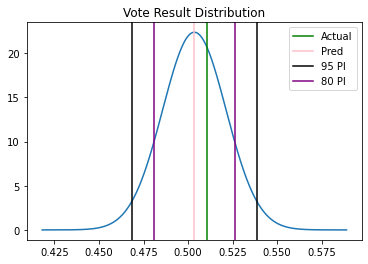

In [12]:
mu = pred_votes
sigma = residuals[-4:,:,:].std(axis=0)[0][0]

x = np.linspace(mu-4*sigma,mu+4*sigma,1000)

plt.plot(x, stats.norm.pdf(x, pred_votes, residuals[-4:,:,:].std(axis=0)[0][1]))

plt.axvline(222/435, label="Actual", color="green")

plt.axvline(mu, label="Pred", color="pink")

plt.axvline(stats.norm.ppf(0.025, pred_votes, residuals[-4:,:,:].std(axis=0)[0][1]), label="95 PI", color="black")
plt.axvline(stats.norm.ppf(0.975, pred_votes, residuals[-4:,:,:].std(axis=0)[0][1]), color="black")

plt.axvline(stats.norm.ppf(0.1, pred_votes, residuals[-4:,:,:].std(axis=0)[0][1]), label="80 PI", color="purple")
plt.axvline(stats.norm.ppf(0.9, pred_votes, residuals[-4:,:,:].std(axis=0)[0][1]), color="purple")

plt.legend()

plt.title("Vote Result Distribution")

plt.show()

From this analysis we seem to find further validation of our prior analyses, that the outcome fell well within the range of our expected outcomes, and perhaps even unusually close.

## Proposed Hyptheses

### Factor Analysis

When I created my model, I deliberately split it into 3 categories of input variables: incumbent factors, economic factors, and polling factors. We can try to ascertain how much each mattered, by training models which isolate only these factors:

In [13]:
factor_types = {}

incumb_factors = ['year', 'is_midterm_year', 'rep_pres', 'RepSeatShare_prior',
         'RepVoteShare_prior']
econ_factors = ['absolute_sentiment', 'sentiment_change', 'absolute_gdp', 'gdp_change',
         'rdi', 'rdi_change']
poll_factors = ['annual_poll_approval', 'two_month_poll_approval',
         'annual_poll_disapproval', 'two_month_poll_disapproval', 'annual_dem',
         'two_month_dem', 'annual_rep', 'two_month_rep']

factor_types["Incumbent Factors"] = incumb_factors
factor_types["Economic Factors"] = econ_factors
factor_types["Polling Factors"] = poll_factors

factor_types

{'Incumbent Factors': ['year',
  'is_midterm_year',
  'rep_pres',
  'RepSeatShare_prior',
  'RepVoteShare_prior'],
 'Economic Factors': ['absolute_sentiment',
  'sentiment_change',
  'absolute_gdp',
  'gdp_change',
  'rdi',
  'rdi_change'],
 'Polling Factors': ['annual_poll_approval',
  'two_month_poll_approval',
  'annual_poll_disapproval',
  'two_month_poll_disapproval',
  'annual_dem',
  'two_month_dem',
  'annual_rep',
  'two_month_rep']}

In [14]:
all_infos = []
for key in all_types_data.keys():

    model_info = {}

    model_info["types"] = key

    model_data = pd.DataFrame(all_types_data[key])

    model = model_data.iloc[5]["model"]

    cols = []
    for k in key:
        cols.extend(factor_types[k])

    predictions = [
    {"seat_share": model.estimators_[i].predict(data_2022[cols])[0][0], 
    "vote_share": model.estimators_[i].predict(data_2022[cols])[0][1]} 
    for i in range(len(model.estimators_))
    ]

    model_info["seat_share"] = model.predict(data_2022[cols])[0][0]
    model_info["seat_amt"] = round(model.predict(data_2022[cols])[0][0]*435)

    model_info["seat_lwr"] = stats.norm.ppf(0.025, model.predict(data_2022[cols])[0][0], model_data.iloc[5]["Seat Share Residual Std"][0])
    model_info["seat_upr"] = stats.norm.ppf(0.975, model.predict(data_2022[cols])[0][0], model_data.iloc[5]["Seat Share Residual Std"][0])

    model_info["seat_lwr_rf"] = list(pd.DataFrame(predictions)["vote_share"].quantile([0.025,0.975]))[0]
    model_info["seat_upr_rf"] = list(pd.DataFrame(predictions)["vote_share"].quantile([0.025,0.975]))[1]

    model_info["vote_share"] = model.predict(data_2022[cols])[0][1]

    model_info["vote_lwr"] = stats.norm.ppf(0.025, model.predict(data_2022[cols])[0][0], model_data.iloc[5]["Vote Share Residual Std"][0])
    model_info["vote_upr"] = stats.norm.ppf(0.975, model.predict(data_2022[cols])[0][0], model_data.iloc[5]["Vote Share Residual Std"][0])

    model_info["vote_lwr_rf"] = list(pd.DataFrame(predictions)["vote_share"].quantile([0.025,0.975]))[0]
    model_info["vote_upr_rf"] = list(pd.DataFrame(predictions)["vote_share"].quantile([0.025,0.975]))[1]

    model_info["seat_std"] = model_data.iloc[5]["Seat Share Residual Std"][0]
    model_info["vote_std"] = model_data.iloc[5]["Vote Share Residual Std"][0]

    all_infos.append(model_info)

We can see that training on these different subsets of the factors leads to wildly different outcomes

In [15]:
pd.DataFrame(all_infos)

,types,seat_share,seat_amt,seat_lwr,seat_upr,seat_lwr_rf,seat_upr_rf,vote_share,vote_lwr,vote_upr,vote_lwr_rf,vote_upr_rf,seat_std,vote_std
0,"(Incumbent Factors,)",0.527811,230,0.422042,0.633580,0.457170,0.535956,0.505696,0.476730,0.578892,0.457170,0.535956,0.053965,0.026062
1,"(Economic Factors,)",0.448445,195,0.347813,0.549076,0.439036,0.534744,0.473486,0.400752,0.496138,0.439036,0.534744,0.051343,0.024334
2,"(Polling Factors,)",0.535939,233,0.423004,0.648873,0.444394,0.535956,0.514160,0.485542,0.586336,0.444394,0.535956,0.057621,0.025713
3,"(Incumbent Factors, Economic Factors)",0.497445,216,0.402710,0.592179,0.439036,0.535956,0.491451,0.449529,0.545360,0.439036,0.535956,0.048335,0.024447
4,"(Incumbent Factors, Polling Factors)",0.530924,231,0.428185,0.633663,0.444394,0.535956,0.510943,0.481632,0.580216,0.444394,0.535956,0.052419,0.025150
5,"(Economic Factors, Polling Factors)",0.510458,222,0.404343,0.616573,0.439036,0.535956,0.500649,0.461319,0.559596,0.439036,0.535956,0.054141,0.025071
6,"(Incumbent Factors, Economic Factors, Polling ...",0.515673,224,0.417900,0.613446,0.444394,0.535956,0.503504,0.468056,0.563290,0.444394,0.535956,0.049885,0.024295


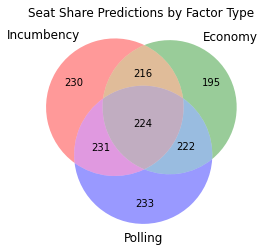

In [16]:
venn3(subsets = (230, 195, 216, 233, 231, 222, 224), set_labels = ('Incumbency', 'Economy', 'Polling'))
plt.title("Seat Share Predictions by Factor Type")
plt.show()

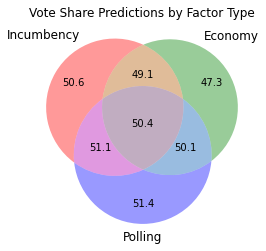

In [17]:
venn3(subsets = (50.6, 47.3, 49.1, 51.4, 51.1, 50.1, 50.4), set_labels = ('Incumbency', 'Economy', 'Polling'))
plt.title("Vote Share Predictions by Factor Type")
plt.show()

From this information, we see that roughly that polling was the most predictive of a Republican victory, incumbency favored the Republicans, but only slightly, and the economy favored the Democrats (with the largest magnitude).

It is unclear exactly why each of these variables has the effect. However, I do have some hyptheses:

* Polling:
    - My polling only includes two types: generic ballot and presidential approval. Both of these factors favored Republicans. My point estimate of the generic ballot gave Republicans a 50.6\% compared to 49.4\% for the Democrats (although I gave my model more generic ballot data). Therefore, an intuitive result for why my model gave a 51.4\% to Republicans is due to adjusting that 50.6\% number more in favor of Republicans due to low presidential approval polling.

* Incumbency:
    - Republicans are slightly favored due to the being a midterm year not in the president's party. However, the inclusion of the "year" term has a high weight towards the Democrats, given their success in 2020 and 2018. WHen I conducted LASSO regression, the only two important terms were "year" and "consumer sentiment". The large potential weight given to year would act to moderate the typical midterm year advantage for Republicans.

* Economy:
    - This factor not only favors Democrats, but favors them more than either polling or incumbency favors Republicans. This is the least clear explanation for me, although I will posit two possible. The first is that Democrats do well in bad economies. The second is that the recent directionality has improved in the past few months, allowing people to forgive the democrats.
    - Upon analysis here, I found a data error which likely will change my results drastically: I had incorrectly coded the 2022 RDI change estimate as absolute RDI (44K) instead of the annual change (~-0.2). This probably caused all the positive results incorrectly. Luckily due to the non-linearity of the random forest model, this far outlier was somewhat masked. Unfortunately, this also meant it was harder to catch (until this very moment.)

## Hypothesis Testing

* Polling
    - I would like to run predictions with just the generic ballot and then just the presidential approval, doing a similar venn diagram (this time with two circles). If the two results were somewhat additive (e.g. ballot 225, presidential 224, combined 230), this would provide evidence that together they strengthend confidence in a R lean.
* Incumbency
    - Likewise, a 3 way venn diagram with year, midterm year, and prior seat/vote share would highlight which was the most important. If my theory were correct, "year" would act as a moderating influence on midterm + prior values, bringing the value closer in line with Democrats.
* Economy
    - For economy, I would perform a different analysis. I would instead seek to find the economic values which would make the prediction most correct. This hypothesis would test whether the underlying economic data misrepresented the overall economic sentiment. If the test found that the "correct" economic inputs were close to the measured values, then this would provide evidence of a potential ecnomic measurement error. In my training data, I used values from the "future" (I used October data, which was unavailable at prediction time), and this would provide evidence of mismeasurement. If, however, the "correct" economic data was a large distance from the measured values, perhaps this would show that economic sentiment is a noisy predictor/voter behavior is explained by other factors (e.g. election denialism).

## Model Changes

If I were to change my model, the main ways I would change it are:

1. District level model
    - I did not use a district level model because my out of sample error was consistently larger than 538's model, leading me to assume that 538's model is a gold standard. However, the creation of a district level model would allow me to get greater degrees of regional insight into where the model failed, and thus would be easier to analyze, even if it was more inaccurate. Furthermore, I would like to take a look at creating a neural district similarity to replace 538's "CANTOR". 538 doesn't explain exactly how CANTOR is constructed, but I think borrowing from the latest approaches in machine learning to create an autoencoder (which learns a district representation) to then use that in the similarity for missing data, could potentially lead to better results. 
2. District level contribution data
    - Likewise, the second improvement over 538 would be to use district-level contribution data. 538 found that in-state contributions were more predictive than national contributions, and I believe this trend would hold. I created an initial approximation of this by mapping contributions to ZIP Codes, and ZIP Codes to Districts, but I believe that my method had some error (due to API limits), and reducing this measurement error would make the model more predictive.
3. (Bonus) Fixing RDI data
    - As explained, my 2022 RDI data was off by a magnitude of 400000x, which likely caused an incorrect reading of the economy. This is my plug to encourage double and triple checking models, which can be very difficult when there are so many places to go wrong. Importantly, I think running checks before publishing (e.g. breaking down by variable type and seeing if they make sense) can help catch these before, and therefore, I would modify my procedure to formalize some of those steps.